# Gold Price Prediction for 2 Years (daily)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

set_seed(455)
np.random.seed(455)

In [ ]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [77]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    print(f"The root mean squared error (RMSE) is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

In [79]:
dataset = pd.read_csv('data/gold/goldstock v1.csv', parse_dates=['Date'], index_col = "Date")
dataset = dataset.iloc[:2511]

In [80]:
dataset

,Unnamed: 0,Close,Volume,Open,High,Low
Date,,,,,,
2024-01-19,0.0,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,1.0,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2.0,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,3.0,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,4.0,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...,...
2014-01-28,2528.0,1250.5,81426.0,1254.9,1261.9,1248.0
2014-01-27,2529.0,1263.5,63419.0,1269.9,1280.1,1252.0
2014-01-24,2530.0,1264.5,34998.0,1264.3,1273.2,1256.9


In [81]:
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index(ascending=True)
dataset['Close'] = dataset['Close'].str.replace(',', '').astype(float)

In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2014-01-22 to 2024-01-19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   float64
 1   Close       2511 non-null   float64
 2   Volume      2511 non-null   object 
 3   Open        2511 non-null   object 
 4   High        2511 non-null   object 
 5   Low         2511 non-null   object 
dtypes: float64(2), object(4)
memory usage: 137.3+ KB


In [83]:
dataset.shape

(2511, 6)

In [84]:
tstart = "2014-01-22"
tend = "2021-12-31"

In [85]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Close"].values
    test = dataset.loc[tend_next:, "Close"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [86]:
test_set

array([1800.1, 1814.6, 1825.1, 1789.2, 1797.4, 1798.8, 1818.5, 1827.3,
       1821.4, 1816.5, 1812.4, 1845.5, 1844.9, 1834.1, 1844.2, 1855. ,
       1832. , 1795. , 1786.6, 1796.4, 1801.5, 1810.3, 1804.1, 1807.8,
       1821.8, 1827.9, 1836.6, 1837.4, 1842.1, 1869.4, 1856.2, 1871.5,
       1902. , 1899.8, 1907.4, 1910.4, 1926.3, 1887.6, 1900.7, 1943.8,
       1922.3, 1935.9, 1966.6, 1995.9, 2043.3, 1988.2, 2000.4, 1985. ,
       1960.8, 1929.7, 1909.2, 1948.2, 1933.9, 1934.8, 1926.7, 1942.6,
       1967.7, 1959.8, 1944.7, 1918. , 1939. , 1954. , 1923.7, 1934. ,
       1927.5, 1923.1, 1937.8, 1945.6, 1948.2, 1976.1, 1984.7, 1974.9,
       1986.4, 1959. , 1955.6, 1948.2, 1934.3, 1896. , 1904.1, 1888.7,
       1891.3, 1911.7, 1863.6, 1870.6, 1868.8, 1875.7, 1882.8, 1858.6,
       1841. , 1853.7, 1824.6, 1808.2, 1814. , 1818.9, 1822.4, 1847.8,
       1848.4, 1853.9, 1871.4, 1852.5, 1853.9, 1857.3, 1848.4, 1848.7,
       1871.4, 1850.2, 1843.7, 1852.1, 1856.5, 1852.8, 1875.5, 1831.8,
      

In [87]:
sc = MinMaxScaler()
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [88]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 120  # Number of time steps to look back
features = 1

X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Reshape for GRU model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [89]:
# The LSTM architecture
model_gru = Sequential()
model_gru.add(GRU(units=256, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the model
model_gru.compile(optimizer="RMSprop", loss="mean_squared_error")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               198912    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 199,169
Trainable params: 199,169
Non-trainable params: 0
_________________________________________________________________


In [90]:
early_stop = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "default_gru.keras",  # File to save the model
    monitor="loss",  # Metric to track (e.g., validation loss)
    save_best_only=True,  # Save only if the model improves
    mode="min",  # Save when 'loss' decreases
    verbose=1  # Print messages when saving
)

# increase epochs to 50 or 100
model_gru.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 0.0038
Epoch 1: loss improved from inf to 0.00382, saving model to default_gru.keras
59/59 [==============================] - 14s 217ms/step - loss: 0.0038
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 0.0013
Epoch 2: loss improved from 0.00382 to 0.00133, saving model to default_gru.keras
59/59 [==============================] - 15s 254ms/step - loss: 0.0013
Epoch 3/25
59/59 [==============================] - ETA: 0s - loss: 9.5321e-04
Epoch 3: loss improved from 0.00133 to 0.00095, saving model to default_gru.keras
59/59 [==============================] - 18s 300ms/step - loss: 9.5321e-04
Epoch 4/25
59/59 [==============================] - ETA: 0s - loss: 7.8632e-04
Epoch 4: loss improved from 0.00095 to 0.00079, saving model to default_gru.keras
59/59 [==============================] - 18s 302ms/step - loss: 7.8632e-04
Epoch 5/25
59/59 [==============================] - ETA: 0s - loss: 7.3959e-

In [91]:
dataset_total = dataset.loc[:, "Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_gru.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 [==============================] - 2s 84ms/step


In [92]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error (RMSE) is 26.35
The Mean Absolute Error (MAE) is 21.68
The R-squared (R²) score is 0.9387

The Mean Squared Logarithmic Error (MSLE) is 0.000196
The Mean Absolute Percentage Error (MAPE) is 6.44%.


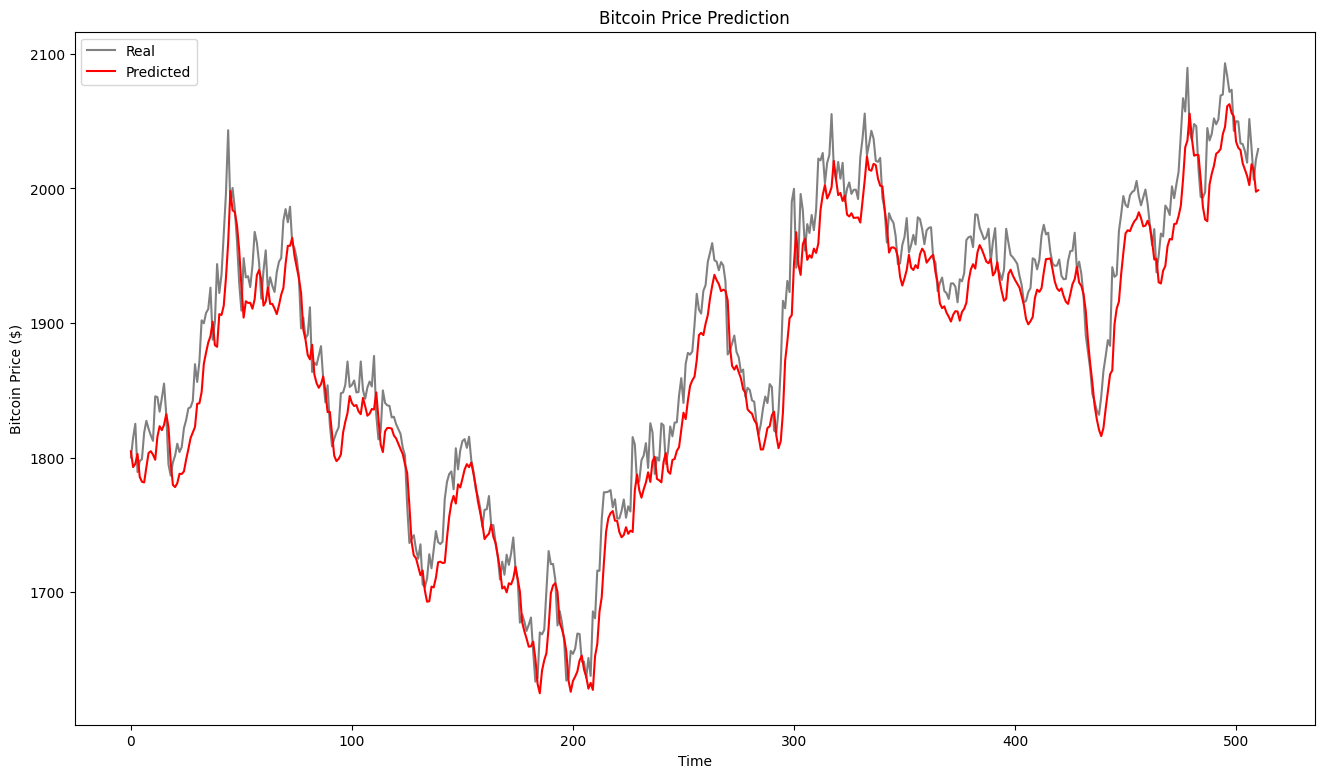

In [93]:
plot_predictions(test_set, predicted_stock_price)